# Cartpole



The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the carptole upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}
\end{equation*}
$$

**Note**: To deal with angle wrap-around issues, we augment the state as follows:

$$
\begin{equation*}
\hat{\textbf{x}} = \begin{bmatrix}
    x & \dot{x} & \dot{\theta} & \sin{\theta} & \cos{\theta}
    \end{bmatrix}
\end{equation*}
$$

**Note**: The force is constrained between $-10$ and $10$ N.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
import numpy as np

In [6]:
DT = 0.1  # Time step (s).
RENDER = True  # Whether to render the environment or not.
N = 25 # Horizon length.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.cartpole.CartpoleCost()
model = pddp.examples.cartpole.CartpoleDynamicsModel(DT)
env = pddp.examples.cartpole.CartpoleEnv(dt=DT, render=RENDER)

In [8]:
def plot(Z, U):
    t = np.arange(N + 1) * DT
    X = pddp.utils.angular.reduce_state(Z, model.angular_indices,
                                        model.non_angular_indices)
    X = X.detach().numpy()
    U = model.constrain(U).detach().numpy()

    x = X[:, 0]
    x_dot = X[:, 1]
    theta = np.unwrap(X[:, 2])  # Makes for smoother plots.
    theta_dot = X[:, 3]
    
    plt.figure()
    plt.plot(theta, theta_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Orientation Phase Plot")

    plt.figure()
    plt.plot(t, x)
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position path")
    
    plt.figure()
    plt.plot(t, x_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m / s)")
    plt.title("Velocity path")
    
    plt.figure()
    plt.plot(t, theta)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Orientation path")

    plt.figure()
    plt.plot(t, theta_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Angular velocity path")
    
    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.title("Constrained action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [9]:
def on_iteration(iteration, Z, U, J_opt, accepted, converged):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    info = "CONVERGED" if converged else ("accepted" if accepted else "FAILED")
    final_state = pddp.utils.angular.reduce_state(Z[-1], model.angular_indices,
                                                  model.non_angular_indices)
    print("iteration", iteration + 1, info, J_opt, final_state.detach().numpy())

In [10]:
controller = pddp.controllers.PDDPController(env, model, cost)

In [11]:
U = torch.randn(N, model.action_size)

In [12]:
J_hist = []
controller.eval()
Z, U = controller.fit(U, encoding=ENCODING, n_iterations=200, on_iteration=on_iteration)

iteration 1 accepted 138.65202 [-0.20008746  0.42068672  0.33668715  0.7320367 ]
iteration 2 accepted 51.430874 [-0.01733498 -0.02398854  0.0830399   0.22460651]
iteration 3 FAILED 51.430874 [-0.01733498 -0.02398854  0.0830399   0.22460651]
iteration 4 FAILED 51.430874 [-0.01733498 -0.02398854  0.0830399   0.22460651]
iteration 5 accepted 44.70724 [-0.04202458  0.044469   -0.03788887 -0.12362647]
iteration 6 accepted 40.558186 [-0.00746162 -0.00795072 -0.00441422  0.05162215]
iteration 7 accepted 38.19144 [-0.01482621  0.0218817  -0.03706381  0.08370388]
iteration 8 accepted 37.08969 [-0.03591979  0.01697564 -0.0034952   0.0048784 ]
iteration 9 FAILED 37.08969 [-0.03591979  0.01697564 -0.0034952   0.0048784 ]
iteration 10 FAILED 37.08969 [-0.03591979  0.01697564 -0.0034952   0.0048784 ]
iteration 11 FAILED 37.08969 [-0.03591979  0.01697564 -0.0034952   0.0048784 ]
iteration 12 FAILED 37.08969 [-0.03591979  0.01697564 -0.0034952   0.0048784 ]
iteration 13 accepted 36.92907 [-0.03023374 

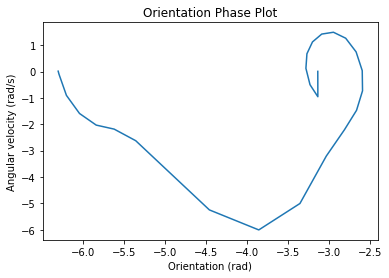

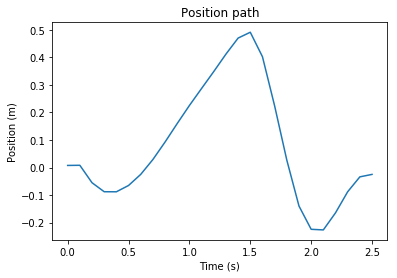

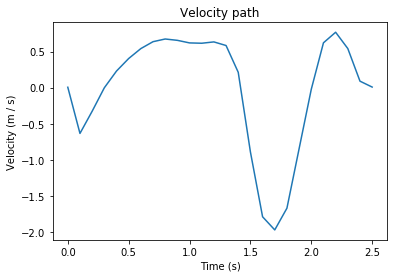

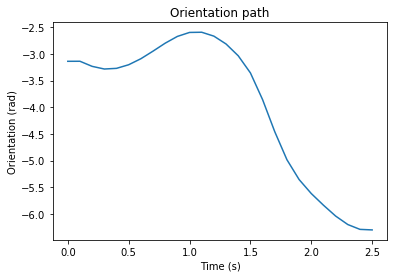

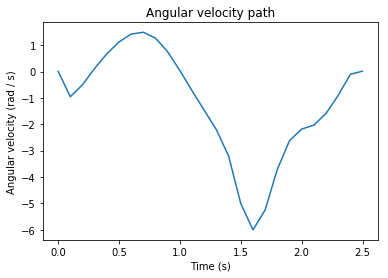

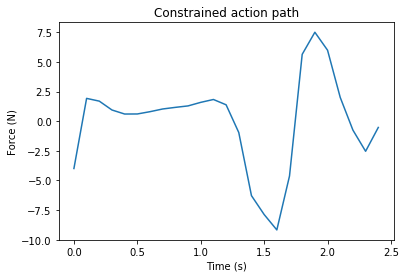

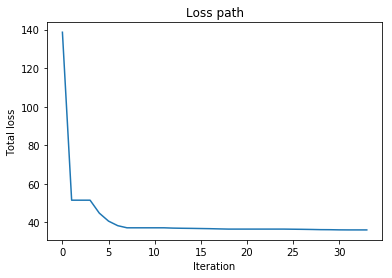

In [13]:
plot(Z, U)

In [14]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [15]:
import time

for u in U:
    env.apply(u)
    time.sleep(DT)

In [16]:
env.close()